In [41]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("✅ GPU tersedia:", gpus)
else:
    print("⚠️ GPU tidak tersedia, pakai CPU")


✅ GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = 'dataset/train/'
test_dir = 'dataset/test/'

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS_BASE = 25
EPOCHS_FINE = 25
LR_BASE = 1e-4
LR_FINE = 1e-5

In [44]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_data = train_gen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = train_gen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    "dataset/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

classes = list(train_data.class_indices.keys())
print(classes)

NUM_CLASSES = train_data.num_classes

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [45]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze SEMUA layer awal
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(NUM_CLASSES, activation="softmax")(x)

model_vgg = Model(inputs=base_model.input, outputs=output)


In [46]:
model_vgg.compile(
    optimizer=Adam(LR_BASE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [47]:
counter = Counter(train_data.classes)
max_count = float(max(counter.values()))

class_weights = {
    cls: max_count / count
    for cls, count in counter.items()
}

print("Class weights:", class_weights)

Class weights: {0: 1.8060075093867334, 1: 16.53868194842407, 2: 1.7608297742525931, 3: 1.0, 4: 1.4531722054380665, 5: 1.4937888198757765, 6: 2.275128104059913}


In [48]:
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]

history_base = model_vgg.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_BASE,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25


2025-12-25 21:59:32.941701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


718/718 [==============================] - ETA: 0s - loss: 4.5637 - accuracy: 0.2143

2025-12-25 22:02:13.974846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


718/718 [==============================] - 201s 278ms/step - loss: 4.5637 - accuracy: 0.2143 - val_loss: 1.9629 - val_accuracy: 0.3097 - lr: 1.0000e-04
Epoch 2/25
718/718 [==============================] - 203s 283ms/step - loss: 3.9452 - accuracy: 0.2627 - val_loss: 1.8076 - val_accuracy: 0.3553 - lr: 1.0000e-04
Epoch 3/25
718/718 [==============================] - 199s 277ms/step - loss: 3.6319 - accuracy: 0.2976 - val_loss: 1.7016 - val_accuracy: 0.3829 - lr: 1.0000e-04
Epoch 4/25
718/718 [==============================] - 199s 277ms/step - loss: 3.4374 - accuracy: 0.3144 - val_loss: 1.6722 - val_accuracy: 0.3747 - lr: 1.0000e-04
Epoch 5/25
718/718 [==============================] - 199s 278ms/step - loss: 3.2541 - accuracy: 0.3291 - val_loss: 1.6485 - val_accuracy: 0.3905 - lr: 1.0000e-04
Epoch 6/25
718/718 [==============================] - 216s 301ms/step - loss: 3.1055 - accuracy: 0.3432 - val_loss: 1.5971 - val_accuracy: 0.4160 - lr: 1.0000e-04
Epoch 7/25
718/718 [=============

In [49]:
for layer in base_model.layers[-6:]:
    layer.trainable = True

model_vgg.compile(
    optimizer=Adam(LR_FINE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [50]:
history_fine = model_vgg.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25


2025-12-25 23:28:11.511045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


718/718 [==============================] - ETA: 0s - loss: 2.3647 - accuracy: 0.4694

2025-12-25 23:31:17.280249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


718/718 [==============================] - 225s 307ms/step - loss: 2.3647 - accuracy: 0.4694 - val_loss: 1.3400 - val_accuracy: 0.4895 - lr: 1.0000e-05
Epoch 2/25
718/718 [==============================] - 223s 310ms/step - loss: 2.2120 - accuracy: 0.5030 - val_loss: 1.3095 - val_accuracy: 0.5037 - lr: 1.0000e-05
Epoch 3/25
718/718 [==============================] - 233s 324ms/step - loss: 2.0991 - accuracy: 0.5278 - val_loss: 1.2401 - val_accuracy: 0.5327 - lr: 1.0000e-05
Epoch 4/25
718/718 [==============================] - 228s 318ms/step - loss: 2.0355 - accuracy: 0.5389 - val_loss: 1.2075 - val_accuracy: 0.5536 - lr: 1.0000e-05
Epoch 5/25
718/718 [==============================] - 230s 321ms/step - loss: 1.9406 - accuracy: 0.5534 - val_loss: 1.1872 - val_accuracy: 0.5550 - lr: 1.0000e-05
Epoch 6/25
718/718 [==============================] - 235s 327ms/step - loss: 1.8811 - accuracy: 0.5761 - val_loss: 1.1693 - val_accuracy: 0.5685 - lr: 1.0000e-05
Epoch 7/25
718/718 [=============

In [54]:
y_true = test_data.classes

y_pred = np.argmax(
    model_vgg.predict(test_data, verbose=1),
    axis=1
)

report = classification_report(
        y_true,
        y_pred,
        target_names=classes,
        digits=4,
        output_dict=True
    )

print(
    classification_report(
        y_true,
        y_pred,
        target_names=classes,
        digits=4
    )
)

2025-12-26 01:04:32.126463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


225/225 [==============================] - 47s 210ms/step
              precision    recall  f1-score   support

       angry     0.6582    0.4843    0.5580       958
     disgust     0.5182    0.6396    0.5726       111
        fear     0.5812    0.4053    0.4776      1024
       happy     0.8789    0.8140    0.8452      1774
     neutral     0.5770    0.6472    0.6101      1233
         sad     0.4708    0.6455    0.5445      1247
    surprise     0.7483    0.7978    0.7723       831

    accuracy                         0.6492      7178
   macro avg     0.6332    0.6334    0.6257      7178
weighted avg     0.6635    0.6492    0.6491      7178



In [55]:
import pandas as pd

df_report = pd.DataFrame(report).transpose()
df_report.to_csv("results_vgg/vgg_classification_report.csv")

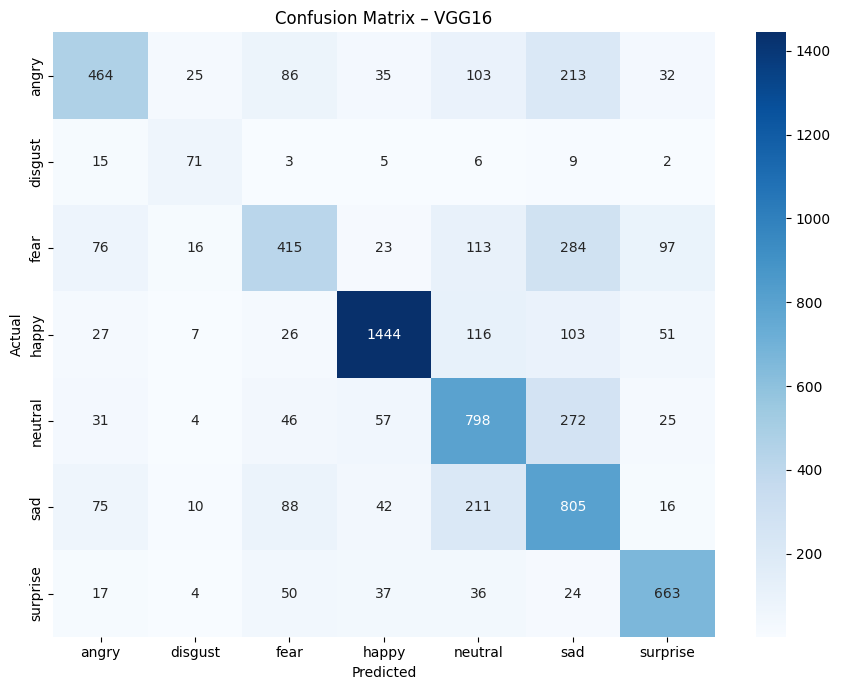

In [56]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – VGG16")
plt.savefig("results_vgg/vgg_confusion_matrix.png", dpi=300)
plt.tight_layout()
plt.show()

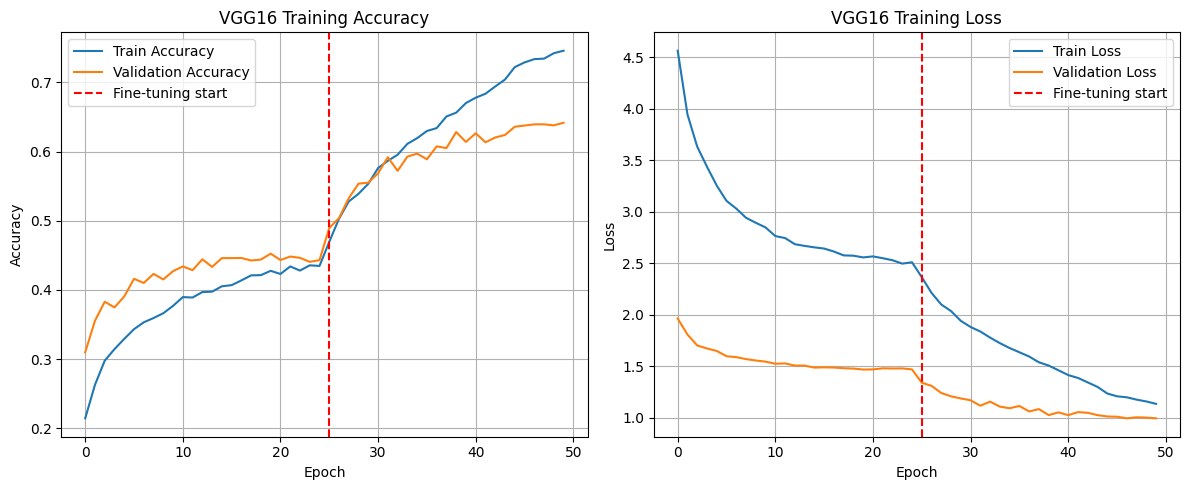

In [57]:
def combine_history(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

history_all = combine_history(history_base, history_fine)
acc_key = 'accuracy' if 'accuracy' in history_all else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history_all else 'val_acc'

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_all[acc_key], label='Train Accuracy')
plt.plot(history_all[val_acc_key], label='Validation Accuracy')
plt.axvline(x=len(history_base.history[acc_key]), color='r', linestyle='--', label='Fine-tuning start')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16 Training Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_all['loss'], label='Train Loss')
plt.plot(history_all['val_loss'], label='Validation Loss')
plt.axvline(x=len(history_base.history['loss']), color='r', linestyle='--', label='Fine-tuning start')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Training Loss')
plt.legend()
plt.grid(True)

plt.savefig("results_vgg/vgg_loss_accuracy.png", dpi=300)
plt.tight_layout()
plt.show()


In [58]:
model_vgg.save("results_vgg/vgg_model.h5")